

## Lorenz attractor originally used by [Lorentz system](https://en.wikipedia.org/wiki/Lorenz_system) consists of three differential equations:

\begin{align*}
&\frac{\mathrm{d}x}{\mathrm{d}t} = \sigma(y - x) ,\\[1em]
&\frac{\mathrm{d}y}{\mathrm{d}t} = x(\rho - z) - y,\\[1em]
&\frac{\mathrm{d}z}{\mathrm{d}t} = xy - \beta z - u_1.
\end{align*}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.interpolate
from mpl_toolkits.mplot3d import Axes3D
from improve_dmdc import Improved_DMDc_new, Standard_DMDC

# Lorenz system parameters
sigma, rho, beta = 10.0, 28.0, 8.0 / 3.0
integrator_keywords = {'rtol': 1e-12, 'method': 'LSODA', 'atol': 1e-12}

# Lorenz ODE with control
def ode_Lorenz(t, xyz, uu):
    x, y, z = xyz
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z + uu
    return [dx_dt, dy_dt, dz_dt]

# Simulation function
def SciPy_Lorenz(t_begin, t_end, x_init, y_init, z_init, t_space, u_con=None):
    if u_con is not None:
        u_interp = scipy.interpolate.interp1d(t_space, u_con, kind='previous', bounds_error=False, fill_value=(u_con[0], u_con[-1]))
        def ode_fun(t, xyz):
            return ode_Lorenz(t, xyz, u_interp(t))
    else:
        def ode_fun(t, xyz):
            return ode_Lorenz(t, xyz, 0.0)
    num_sol = solve_ivp(ode_fun, [t_begin, t_end], [x_init, y_init, z_init], **integrator_keywords, t_eval=t_space)
    return num_sol.y[0], num_sol.y[1], num_sol.y[2]


In [2]:
# Simulation parameters
t_init, t_end, delta_t = 0, 50, 0.003
x_init, y_init, z_init = 1.0, 1.0, 1.0
N_t = int((t_end - t_init) / delta_t) + 1
t_array = np.linspace(t_init, t_end, N_t)
u_con = (2 * np.sin(t_array) * np.sin(t_array / 10)) ** 2
x_solved, y_solved, z_solved = SciPy_Lorenz(t_begin=t_init, t_end=t_end, x_init=x_init, y_init=y_init, z_init=z_init, t_space=t_array, u_con=u_con)

# Training data
N_train = int(N_t * 0.8)
x_train = x_solved[:N_train]
y_train = y_solved[:N_train]
z_train = z_solved[:N_train]
t_train = t_array[:N_train]
X_data = np.vstack((x_train, y_train, z_train))
U_control = u_con[:N_train-1].reshape(1, -1)

# Apply Improved DMDc
rank_p, rank_r = 20, 10
eigenvalues, modes, recons, bar_A, bar_B, bar_V, time_improved = Improved_DMDc_new(X_data, U_control, rank_p, rank_r)
eigenvalues_std, modes_std, recons_std, bar_A_std, bar_B_std, bar_V_std, time_standard = Standard_DMDC(X_data, U_control, rank_p, rank_r)

# Predict future states for improved DMDc
X_data_test = np.vstack((x_solved[N_train-1], y_solved[N_train-1], z_solved[N_train-1])).reshape(3, 1)
z_k = bar_V.T @ X_data_test
future_steps = N_t - N_train + 1
Y_pred = np.zeros((3, future_steps))
z_current = z_k.reshape(-1, 1)

for i in range(future_steps):
    u_current = u_con[N_train-1+i].reshape(1, -1)
    z_next = bar_A @ z_current + bar_B @ u_current
    Y_pred[:, i] = (bar_V @ z_next).reshape(3,)
    z_current = z_next

# Predict future states for standard DMDc
X_data_test_std = np.vstack((x_solved[N_train-1], y_solved[N_train-1], z_solved[N_train-1])).reshape(3, 1)
z_k_std = bar_V_std.T @ X_data_test_std
future_steps = N_t - N_train + 1
Y_pred_std = np.zeros((3, future_steps))
z_current_std = z_k_std.reshape(-1, 1)

for i in range(future_steps):
    u_current = u_con[N_train-1+i].reshape(1, -1)
    z_next_std = bar_A_std @ z_current_std + bar_B_std @ u_current
    Y_pred_std[:, i] = (bar_V_std @ z_next_std).reshape(3,)
    z_current_std = z_next_std

the shape of X_data is:  (3, 13333)
the shape of U_control.shape[1] + 1 is:  13333


In [3]:
print(modes_std)
print(eigenvalues_std)

[[ 0.08429434+0.j         -0.64862169+0.16450892j -0.64862169-0.16450892j]
 [ 0.08431002+0.j         -0.72409367-0.15208896j -0.72409367+0.15208896j]
 [-0.99287312+0.j          0.04548585-0.04791258j  0.04548585+0.04791258j]]
[1.00000538+0.j         0.99968382+0.01458831j 0.99968382-0.01458831j]


In [4]:
# Compute RMSE and relative error for each state variable (x, y, z)
def compute_relative_error(original, reconstructed):
    return np.linalg.norm(original - reconstructed, axis=1) / np.linalg.norm(original, axis=1)

def compute_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2, axis=1))

# Errors for Improved DMDc
rel_error_improved = compute_relative_error(X_data[:, :-1], recons)
rmse_improved = compute_rmse(X_data[:, :-1], recons)

# Errors for Standard DMDc
rel_error_std = compute_relative_error(X_data[:, :-1], recons_std)
rmse_std = compute_rmse(X_data[:, :-1], recons_std)

# Print comparison
print("Error Comparison for Improved and Standard DMDc:")
print(f"{'Variable':<10} {'Method':<15} {'Relative Error':<15} {'RMSE':<10}")
print("-" * 50)
for idx, var in enumerate(['x', 'y', 'z']):
    print(f"{var:<10} {'Improved DMDc':<15} {rel_error_improved[idx]:<15.4f} {rmse_improved[idx]:<10.4f}")
    print(f"{var:<10} {'Standard DMDc':<15} {rel_error_std[idx]:<15.4f} {rmse_std[idx]:<10.4f}")
    print("-" * 50)

Error Comparison for Improved and Standard DMDc:
Variable   Method          Relative Error  RMSE      
--------------------------------------------------
x          Improved DMDc   0.0138          0.1112    
x          Standard DMDc   0.0138          0.1112    
--------------------------------------------------
y          Improved DMDc   0.0138          0.1220    
y          Standard DMDc   0.0138          0.1220    
--------------------------------------------------
z          Improved DMDc   0.0004          0.0112    
z          Standard DMDc   0.0004          0.0112    
--------------------------------------------------


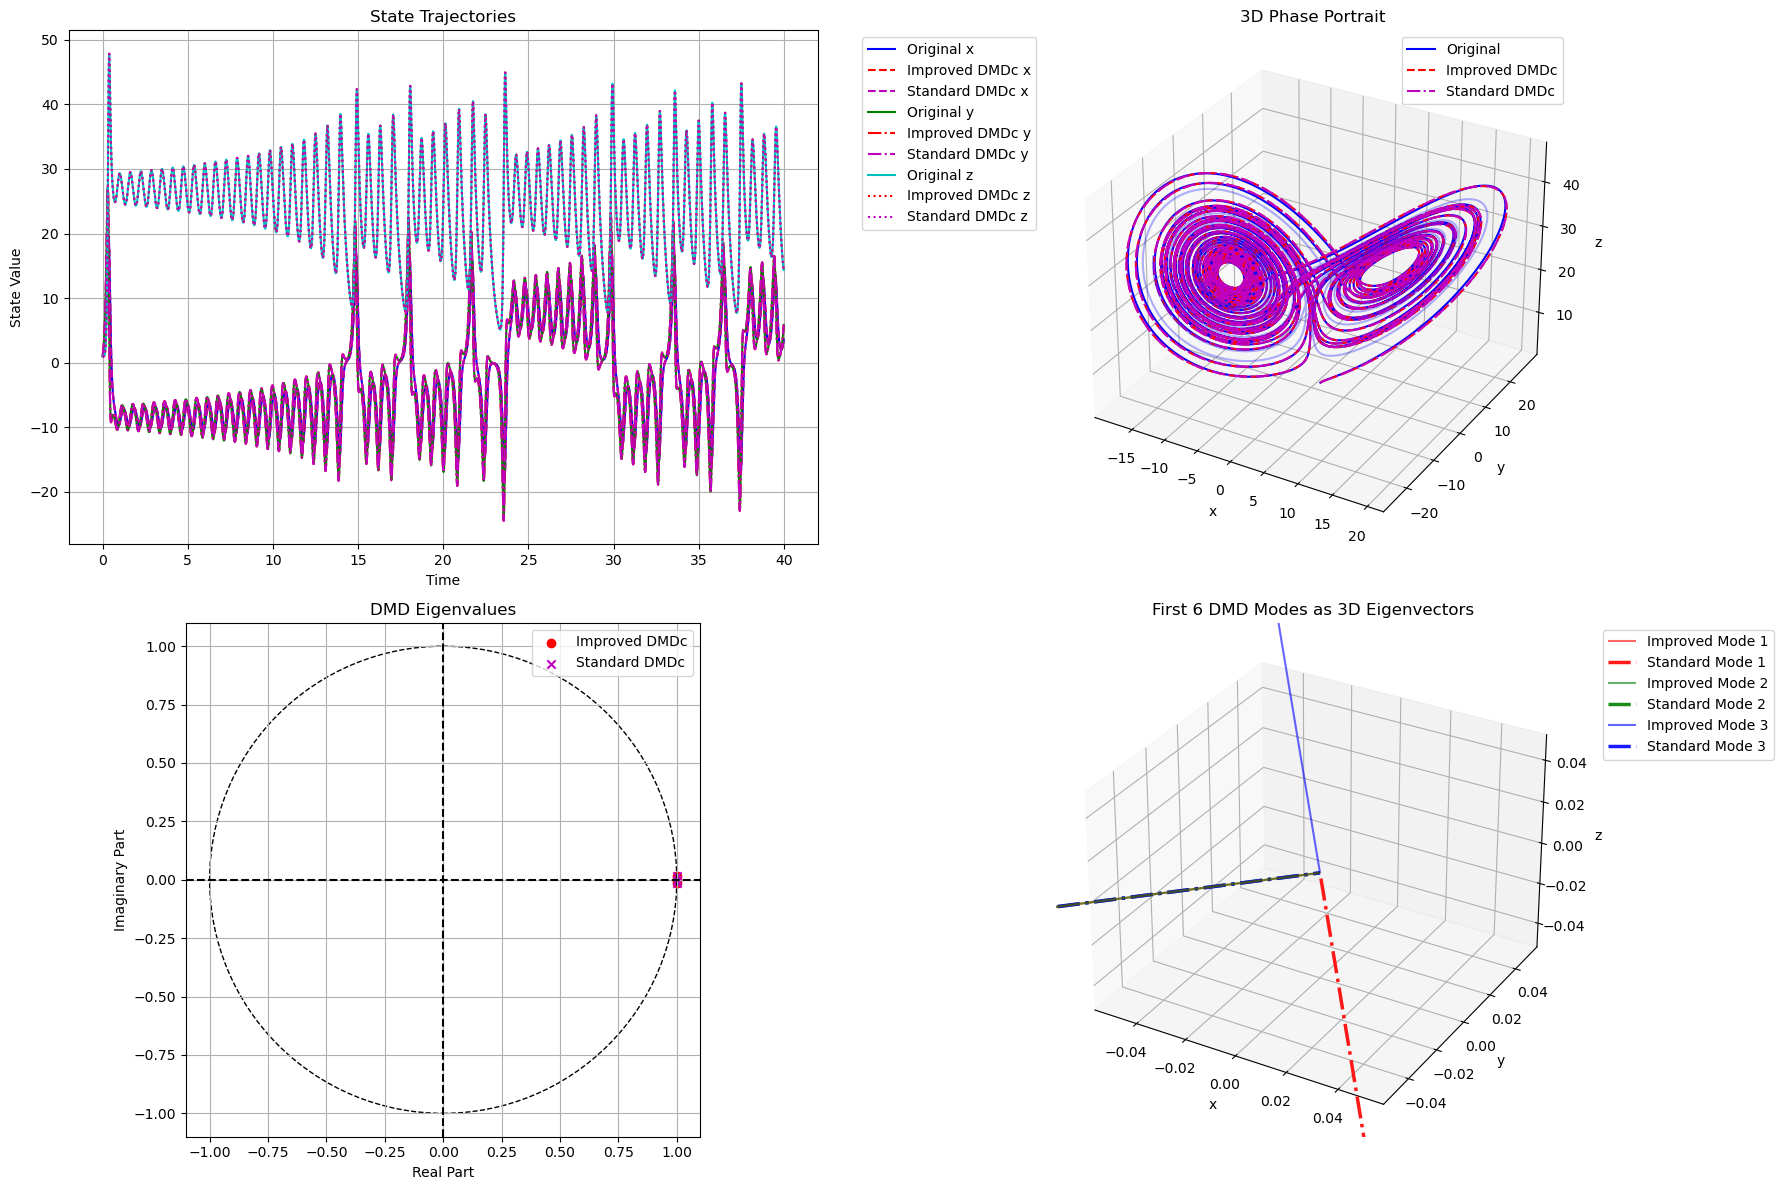

In [11]:
# Create figure with 5 subplots
fig = plt.figure(figsize=(18, 12))

# Plot 1: State trajectories
ax1 = fig.add_subplot(221)
ax1.plot(t_array[:N_train-1], X_data[0, :-1], 'b-', label='Original x')
ax1.plot(t_array[:N_train-1], recons[0, :], 'r--', label='Improved DMDc x')
ax1.plot(t_array[:N_train-1], recons_std[0, :], 'm--', label='Standard DMDc x')
ax1.plot(t_array[:N_train-1], X_data[1, :-1], 'g-', label='Original y')
ax1.plot(t_array[:N_train-1], recons[1, :], 'r-.', label='Improved DMDc y')
ax1.plot(t_array[:N_train-1], recons_std[1, :], 'm-.', label='Standard DMDc y')
ax1.plot(t_array[:N_train-1], X_data[2, :-1], 'c-', label='Original z')
ax1.plot(t_array[:N_train-1], recons[2, :], 'r:', label='Improved DMDc z')
ax1.plot(t_array[:N_train-1], recons_std[2, :], 'm:', label='Standard DMDc z')
# Plot future predictions
# ax1.plot(t_array[N_train-1:], x_solved[N_train-1:], 'b-', alpha=0.3)
# ax1.plot(t_array[N_train-1:], y_solved[N_train-1:], 'g-', alpha=0.3)
# ax1.plot(t_array[N_train-1:], z_solved[N_train-1:], 'c-', alpha=0.3)
# ax1.plot(t_array[N_train-1:], Y_pred[0, :], 'r--', alpha=0.5)
# ax1.plot(t_array[N_train-1:], Y_pred[1, :], 'r-.', alpha=0.5)
# ax1.plot(t_array[N_train-1:], Y_pred[2, :], 'r:', alpha=0.5)
# ax1.plot(t_array[N_train-1:], Y_pred_std[0, :], 'm--', alpha=0.5)
# ax1.plot(t_array[N_train-1:], Y_pred_std[1, :], 'm-.', alpha=0.5)
# ax1.plot(t_array[N_train-1:], Y_pred_std[2, :], 'm:', alpha=0.5)
ax1.set_title('State Trajectories')
ax1.set_xlabel('Time')
ax1.set_ylabel('State Value')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True)

# Plot 2: 3D Phase portrait
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot(X_data[0, :-1], X_data[1, :-1], X_data[2, :-1], 'b-', label='Original')
ax2.plot(recons[0, :], recons[1, :], recons[2, :], 'r--', label='Improved DMDc')
ax2.plot(recons_std[0, :], recons_std[1, :], recons_std[2, :], 'm-.', label='Standard DMDc')
ax2.plot(x_solved[N_train-1:], y_solved[N_train-1:], z_solved[N_train-1:], 'b-', alpha=0.3)
# Plot future predictions
# ax2.plot(Y_pred[0, :], Y_pred[1, :], Y_pred[2, :], 'r--', alpha=0.5)
# ax2.plot(Y_pred_std[0, :], Y_pred_std[1, :], Y_pred_std[2, :], 'm--', alpha=0.5)
ax2.set_title('3D Phase Portrait')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.legend()

# Plot 3: Eigenvalues
ax3 = fig.add_subplot(223)
ax3.scatter(eigenvalues.real, eigenvalues.imag, c='r', marker='o', label='Improved DMDc')
ax3.scatter(eigenvalues_std.real, eigenvalues_std.imag, c='m', marker='x', label='Standard DMDc')
ax3.axhline(0, color='k', linestyle='--')
ax3.axvline(0, color='k', linestyle='--')
circle = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax3.add_artist(circle)
ax3.set_xlim([-1.1, 1.1])
ax3.set_ylim([-1.1, 1.1])
ax3.set_title('DMD Eigenvalues')
ax3.set_xlabel('Real Part')
ax3.set_ylabel('Imaginary Part')
ax3.grid(True)
ax3.set_aspect('equal', adjustable='box')
ax3.legend()

# Plot 4: DMD Modes as 3D eigenvectors (first 6, different colors for each method)
ax4 = fig.add_subplot(224, projection='3d')
num_modes = min(min(modes.shape[1], modes_std.shape[1]), 6)  # Plot up to 6 eigenvectors
colors = ['r', 'g', 'b', 'm', 'c', 'y']

for i in range(num_modes):
    vec_imp = modes[:, i].real
    vec_std = modes_std[:, i].real
    ax4.quiver(0, 0, 0, vec_imp[0], vec_imp[1], vec_imp[2], length=1.0, normalize=True, color=colors[i % len(colors)], alpha=0.6, linewidth=1.5, label=f'Improved Mode {i+1}')
    ax4.quiver(0, 0, 0, vec_std[0], vec_std[1], vec_std[2], length=1.0, normalize=True, color=colors[i % len(colors)], alpha=0.9, linewidth=2.5, linestyle='-.', label=f'Standard Mode {i+1}')
ax4.set_title('First 6 DMD Modes as 3D Eigenvectors')
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_zlabel('z')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True)


plt.tight_layout()
plt.savefig('media/trajectory_lorentz_improved.png.png')


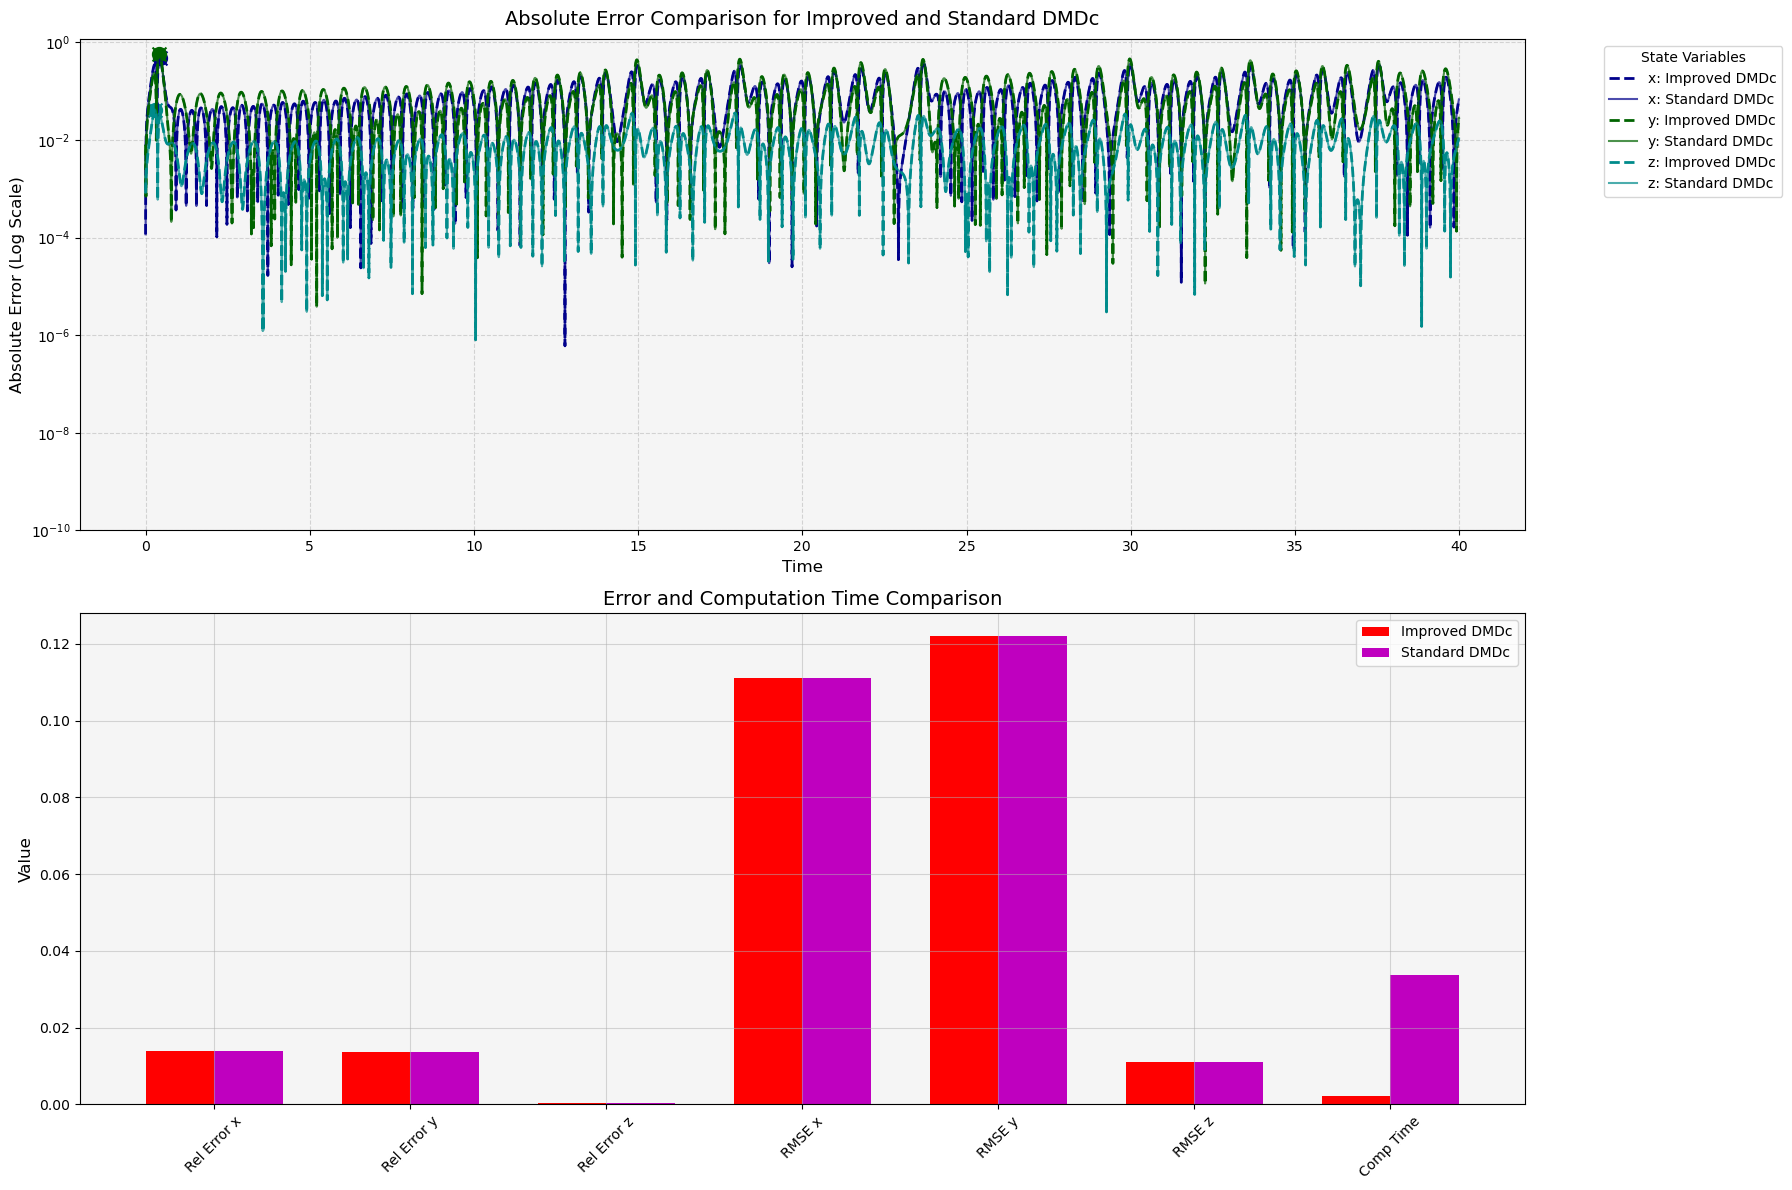

In [12]:

# Create figure with 2 subplots
fig = plt.figure(figsize=(18, 12))

# Plot 1: Absolute Error Comparison (Improved)
ax5 = fig.add_subplot(211)
abs_error_improved = np.abs(X_data[:, :-1] - recons)
abs_error_std = np.abs(X_data[:, :-1] - recons_std)

# Plot errors with grouped colors and different line styles
ax5.plot(t_array[:N_train-1], abs_error_improved[0, :], color='darkblue', linestyle='--', label='x: Improved DMDc', linewidth=2.0)
ax5.plot(t_array[:N_train-1], abs_error_std[0, :], color='darkblue', linestyle='-', label='x: Standard DMDc', linewidth=1.5, alpha=0.7)
ax5.plot(t_array[:N_train-1], abs_error_improved[1, :], color='darkgreen', linestyle='--', label='y: Improved DMDc', linewidth=2.0)
ax5.plot(t_array[:N_train-1], abs_error_std[1, :], color='darkgreen', linestyle='-', label='y: Standard DMDc', linewidth=1.5, alpha=0.7)
ax5.plot(t_array[:N_train-1], abs_error_improved[2, :], color='darkcyan', linestyle='--', label='z: Improved DMDc', linewidth=2.0)
ax5.plot(t_array[:N_train-1], abs_error_std[2, :], color='darkcyan', linestyle='-', label='z: Standard DMDc', linewidth=1.5, alpha=0.7)

# Annotate peak errors for each variable
for i, var in enumerate(['x', 'y', 'z']):
    max_idx_imp = np.argmax(abs_error_improved[i, :])
    max_idx_std = np.argmax(abs_error_std[i, :])
    ax5.scatter(t_array[max_idx_imp], abs_error_improved[i, max_idx_imp], color='darkblue' if i == 0 else 'darkgreen' if i == 1 else 'darkcyan', marker='o', s=100)
    ax5.scatter(t_array[max_idx_std], abs_error_std[i, max_idx_std], color='darkblue' if i == 0 else 'darkgreen' if i == 1 else 'darkcyan', marker='x', s=100)

ax5.set_title('Absolute Error Comparison for Improved and Standard DMDc', fontsize=14, pad=10)
ax5.set_xlabel('Time', fontsize=12)
ax5.set_ylabel('Absolute Error (Log Scale)', fontsize=12)
ax5.set_yscale('log')  # Logarithmic scale for better visibility
ax5.set_ylim(bottom=1e-10)  # Avoid log scale issues with zero
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title='State Variables')
ax5.grid(True, which="both", ls="--", alpha=0.5)
ax5.set_facecolor('#f5f5f5')  # Light background for contrast

# Plot 2: Error and Time Metrics (Unchanged)
ax6 = fig.add_subplot(212)
metrics = ['Rel Error x', 'Rel Error y', 'Rel Error z', 'RMSE x', 'RMSE y', 'RMSE z', 'Comp Time']
values_improved = [rel_error_improved[0], rel_error_improved[1], rel_error_improved[2], rmse_improved[0], rmse_improved[1], rmse_improved[2], time_improved]
values_std = [rel_error_std[0], rel_error_std[1], rel_error_std[2], rmse_std[0], rmse_std[1], rmse_std[2], time_standard]
x = np.arange(len(metrics))
width = 0.35
ax6.bar(x - width/2, values_improved, width, label='Improved DMDc', color='r')
ax6.bar(x + width/2, values_std, width, label='Standard DMDc', color='m')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics, rotation=45)
ax6.set_title('Error and Computation Time Comparison', fontsize=14)
ax6.set_ylabel('Value', fontsize=12)
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.5)
ax6.set_facecolor('#f5f5f5')

plt.tight_layout()
plt.savefig('media/dmdc_error_comparison_improved_lorentz.png')

# question 

+ why in lorenz system, the dynamic for x and y mostly converges, but the dynamics for z axis did not